# Task
Implement an accident prediction model using the Nexar collision dataset on Hugging Face. The model should be trained on visual data only to simulate real-time inference. The implementation should include data loading, exploratory data analysis, frame extraction, feature extraction using a pre-trained video backbone, training a lightweight classifier, and evaluation. Use efficient data handling and provide clear visualizations and structured code blocks. Sample 100 positive and 100 negative videos from the "test-public" split for prototyping.

## Targeted data download and metadata loading

### Subtask:
Download a subset of 100 positive and 100 negative video files and their corresponding metadata from the `test-public` split of the dataset using `hf_hub_download`.


**Reasoning**:
Import necessary libraries, set the HF_TOKEN, define repo_id and revision, list repository files, define and create local download directories, define metadata file paths for the test-public split, download metadata files, load and combine metadata, filter for positive videos with valid time_to_accident, select a subset of positive and negative video files that exist in the repository file list, download the selected video files, create a dictionary of time_to_accident for downloaded positive videos, and print confirmation messages.



In [ ]:
import os
from huggingface_hub import hf_hub_download, list_repo_files
import pandas as pd

# Define the repo_id and revision for the dataset
repo_id = "nexar-ai/nexar_collision_prediction"
revision = "aa97deda5a59f00bb7187739053b7c72e14374df" # Use the specified revision

# Use list_repo_files to get a list of all files in the repository.
all_files = list_repo_files(repo_id=repo_id, repo_type="dataset", revision=revision)

# Define local directory paths for downloading
download_dir = "./accident_prediction_test_public_subset_videos"
metadata_download_dir = "./accident_prediction_test_public_subset_metadata"

# Create download directories if they don't exist
os.makedirs(download_dir, exist_ok=True)
os.makedirs(metadata_download_dir, exist_ok=True)

# Define paths to the metadata files within the 'test-public' split
metadata_files_to_download = [
    "test-public/positive/metadata.csv",
    "test-public/negative/metadata.csv"
]

downloaded_metadata_paths = []
print("Downloading metadata files for test-public split...")
for file_path in metadata_files_to_download:
    try:
        downloaded_path = hf_hub_download(
            repo_id=repo_id,
            filename=file_path,
            repo_type="dataset",
            revision=revision,
            local_dir=metadata_download_dir,
            local_dir_use_symlinks=False # Set to False to actually download the files
        )
        downloaded_metadata_paths.append(downloaded_path)
        print(f"Downloaded: {file_path}")
    except Exception as e:
        print(f"Failed to download {file_path}: {e}")

# Load the downloaded metadata
time_to_accident_dict = {}
positive_files_with_time_in_metadata = []
negative_files_in_metadata = []

if downloaded_metadata_paths:
    try:
        positive_metadata_df = pd.read_csv(os.path.join(metadata_download_dir, "test-public", "positive", "metadata.csv"))
        negative_metadata_df = pd.read_csv(os.path.join(metadata_download_dir, "test-public", "negative", "metadata.csv"))

        # Filter for positive files with valid time_to_accident
        if 'file_name' in positive_metadata_df.columns and 'time_to_accident' in positive_metadata_df.columns:
            positive_with_time_df = positive_metadata_df[positive_metadata_df['time_to_accident'].notna()]
            # Store filenames relative to the repository root
            positive_files_with_time_in_metadata = [f"test-public/positive/{fname}" for fname in positive_with_time_df['file_name'].tolist()]
            # Create a dictionary for quick lookup
            time_to_accident_dict = dict(zip(positive_files_with_time_in_metadata, positive_with_time_df['time_to_accident']))

        # Get negative files from metadata (assuming all negative videos in metadata are relevant)
        if 'file_name' in negative_metadata_df.columns:
             # Store filenames relative to the repository root
            negative_files_in_metadata = [f"test-public/negative/{fname}" for fname in negative_metadata_df['file_name'].tolist()]


        print(f"Found {len(positive_files_with_time_in_metadata)} positive files with time_to_accident in metadata.")
        print(f"Found {len(negative_files_in_metadata)} negative files in metadata.")


    except FileNotFoundError:
        print("Metadata files not found after download.")
    except Exception as e:
        print(f"Error loading or processing metadata: {e}")

# Select a subset of files to download (100 positive with time_to_accident, 100 negative)
num_files_to_download = 100

# Select positive files that are in the metadata and also exist in the repository file list
selected_positive_files = [f for f in sorted(positive_files_with_time_in_metadata) if f in all_files][:num_files_to_download]

# Select negative files that are in the metadata and also exist in the repository file list
selected_negative_files = [f for f in sorted(negative_files_in_metadata) if f in all_files][:num_files_to_download]

downloaded_files_list = []

# Download the selected negative files
print(f"\nDownloading {len(selected_negative_files)} negative files to {download_dir}...")
for file_path in selected_negative_files:
    try:
        downloaded_path = hf_hub_download(
            repo_id=repo_id,
            filename=file_path,
            repo_type="dataset",
            revision=revision,
            local_dir=download_dir,
            local_dir_use_symlinks=False
        )
        downloaded_files_list.append(downloaded_path)
        print(f"Downloaded: {os.path.basename(file_path)}")
    except Exception as e:
        print(f"Failed to download {file_path}: {e}")

# Download the selected positive files
print(f"\nDownloading {len(selected_positive_files)} positive files to {download_dir}...")
for file_path in selected_positive_files:
     try:
        downloaded_path = hf_hub_download(
            repo_id=repo_id,
            filename=file_path,
            repo_type="dataset",
            revision=revision,
            local_dir=download_dir,
            local_dir_use_symlinks=False
        )
        downloaded_files_list.append(downloaded_path)
        print(f"Downloaded: {os.path.basename(file_path)}")
     except Exception as e:
        print(f"Failed to download {file_path}: {e}")


# Update the time_to_accident_dict to only include the downloaded positive files
downloaded_positive_time_to_accident_dict = {
    file_path: time_to_accident_dict[file_path]
    for file_path in selected_positive_files if file_path in time_to_accident_dict
}


# Print confirmation messages
print(f"\nSuccessfully downloaded {len(downloaded_files_list)} video files in total to {download_dir}.")
print(f"Created downloaded_positive_time_to_accident_dict with {len(downloaded_positive_time_to_accident_dict)} entries for downloaded positive videos with valid time_to_accident.")

# Check if any positive videos with time_to_accident were found and downloaded
if not selected_positive_files:
    print("\nWarning: No positive videos with valid time_to_accident were found or selected from the test-public split.")
    print("This might impact subsequent steps requiring time_to_accident information.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


metadata.csv: 0.00B [00:00, ?B/s]

Downloaded: test-public/positive/metadata.csv


metadata.csv: 0.00B [00:00, ?B/s]

Downloaded: test-public/negative/metadata.csv
Found 334 positive files with time_to_accident in metadata.
Found 333 negative files in metadata.



/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


test-public/negative/01044.mp4:   0%|          | 0.00/6.39M [00:00<?, ?B/s]

Downloaded: 01044.mp4


test-public/negative/01056.mp4:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Downloaded: 01056.mp4


test-public/negative/01059.mp4:   0%|          | 0.00/5.37M [00:00<?, ?B/s]

Downloaded: 01059.mp4


test-public/negative/01065.mp4:   0%|          | 0.00/6.12M [00:00<?, ?B/s]

Downloaded: 01065.mp4


test-public/negative/01068.mp4:   0%|          | 0.00/4.52M [00:00<?, ?B/s]

Downloaded: 01068.mp4


test-public/negative/01083.mp4:   0%|          | 0.00/3.68M [00:00<?, ?B/s]

Downloaded: 01083.mp4


test-public/negative/01101.mp4:   0%|          | 0.00/2.62M [00:00<?, ?B/s]

Downloaded: 01101.mp4


test-public/negative/01110.mp4:   0%|          | 0.00/5.12M [00:00<?, ?B/s]

Downloaded: 01110.mp4


test-public/negative/01113.mp4:   0%|          | 0.00/3.51M [00:00<?, ?B/s]

Downloaded: 01113.mp4


test-public/negative/01125.mp4:   0%|          | 0.00/5.90M [00:00<?, ?B/s]

Downloaded: 01125.mp4


test-public/negative/01126.mp4:   0%|          | 0.00/4.03M [00:00<?, ?B/s]

Downloaded: 01126.mp4


test-public/negative/01139.mp4:   0%|          | 0.00/1.86M [00:00<?, ?B/s]

Downloaded: 01139.mp4


test-public/negative/01143.mp4:   0%|          | 0.00/4.86M [00:00<?, ?B/s]

Downloaded: 01143.mp4


test-public/negative/01149.mp4:   0%|          | 0.00/4.97M [00:00<?, ?B/s]

Downloaded: 01149.mp4


test-public/negative/01151.mp4:   0%|          | 0.00/3.19M [00:00<?, ?B/s]

Downloaded: 01151.mp4


test-public/negative/01152.mp4:   0%|          | 0.00/3.95M [00:00<?, ?B/s]

Downloaded: 01152.mp4


test-public/negative/01154.mp4:   0%|          | 0.00/2.32M [00:00<?, ?B/s]

Downloaded: 01154.mp4


test-public/negative/01158.mp4:   0%|          | 0.00/2.74M [00:00<?, ?B/s]

Downloaded: 01158.mp4


test-public/negative/01166.mp4:   0%|          | 0.00/7.40M [00:00<?, ?B/s]

Downloaded: 01166.mp4


test-public/negative/01169.mp4:   0%|          | 0.00/2.55M [00:00<?, ?B/s]

Downloaded: 01169.mp4


test-public/negative/01179.mp4:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

Downloaded: 01179.mp4


test-public/negative/01181.mp4:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

Downloaded: 01181.mp4


test-public/negative/01201.mp4:   0%|          | 0.00/1.83M [00:00<?, ?B/s]

Downloaded: 01201.mp4


test-public/negative/01203.mp4:   0%|          | 0.00/2.79M [00:00<?, ?B/s]

Downloaded: 01203.mp4


test-public/negative/01208.mp4:   0%|          | 0.00/5.54M [00:00<?, ?B/s]

Downloaded: 01208.mp4


test-public/negative/01216.mp4:   0%|          | 0.00/3.72M [00:00<?, ?B/s]

Downloaded: 01216.mp4


test-public/negative/01239.mp4:   0%|          | 0.00/2.81M [00:00<?, ?B/s]

Downloaded: 01239.mp4


test-public/negative/01244.mp4:   0%|          | 0.00/8.63M [00:00<?, ?B/s]

Downloaded: 01244.mp4


test-public/negative/01246.mp4:   0%|          | 0.00/4.41M [00:00<?, ?B/s]

Downloaded: 01246.mp4


test-public/negative/01247.mp4:   0%|          | 0.00/5.59M [00:00<?, ?B/s]

Downloaded: 01247.mp4


test-public/negative/01253.mp4:   0%|          | 0.00/3.01M [00:00<?, ?B/s]

Downloaded: 01253.mp4


test-public/negative/01264.mp4:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

Downloaded: 01264.mp4


test-public/negative/01274.mp4:   0%|          | 0.00/7.37M [00:00<?, ?B/s]

Downloaded: 01274.mp4


test-public/negative/01275.mp4:   0%|          | 0.00/4.51M [00:00<?, ?B/s]

Downloaded: 01275.mp4


test-public/negative/01297.mp4:   0%|          | 0.00/4.22M [00:00<?, ?B/s]

Downloaded: 01297.mp4


test-public/negative/01310.mp4:   0%|          | 0.00/2.51M [00:00<?, ?B/s]

Downloaded: 01310.mp4


test-public/negative/01312.mp4:   0%|          | 0.00/7.26M [00:00<?, ?B/s]

Downloaded: 01312.mp4


test-public/negative/01316.mp4:   0%|          | 0.00/5.31M [00:00<?, ?B/s]

Downloaded: 01316.mp4


test-public/negative/01330.mp4:   0%|          | 0.00/2.65M [00:00<?, ?B/s]

Downloaded: 01330.mp4


test-public/negative/01347.mp4:   0%|          | 0.00/3.06M [00:00<?, ?B/s]

Downloaded: 01347.mp4


test-public/negative/01353.mp4:   0%|          | 0.00/2.04M [00:00<?, ?B/s]

Downloaded: 01353.mp4


test-public/negative/01367.mp4:   0%|          | 0.00/4.99M [00:00<?, ?B/s]

Downloaded: 01367.mp4


test-public/negative/01375.mp4:   0%|          | 0.00/2.54M [00:00<?, ?B/s]

Downloaded: 01375.mp4


test-public/negative/01389.mp4:   0%|          | 0.00/2.95M [00:00<?, ?B/s]

Downloaded: 01389.mp4


test-public/negative/01398.mp4:   0%|          | 0.00/2.16M [00:00<?, ?B/s]

Downloaded: 01398.mp4


test-public/negative/01409.mp4:   0%|          | 0.00/2.68M [00:00<?, ?B/s]

Downloaded: 01409.mp4


test-public/negative/01410.mp4:   0%|          | 0.00/8.10M [00:00<?, ?B/s]

Downloaded: 01410.mp4


test-public/negative/01432.mp4:   0%|          | 0.00/3.26M [00:00<?, ?B/s]

Downloaded: 01432.mp4


test-public/negative/01450.mp4:   0%|          | 0.00/6.21M [00:00<?, ?B/s]

Downloaded: 01450.mp4


test-public/negative/01472.mp4:   0%|          | 0.00/3.49M [00:00<?, ?B/s]

Downloaded: 01472.mp4


test-public/negative/01479.mp4:   0%|          | 0.00/1.69M [00:00<?, ?B/s]

Downloaded: 01479.mp4


test-public/negative/01480.mp4:   0%|          | 0.00/7.31M [00:00<?, ?B/s]

Downloaded: 01480.mp4


test-public/negative/01481.mp4:   0%|          | 0.00/4.51M [00:00<?, ?B/s]

Downloaded: 01481.mp4


test-public/negative/01483.mp4:   0%|          | 0.00/2.96M [00:00<?, ?B/s]

Downloaded: 01483.mp4


test-public/negative/01502.mp4:   0%|          | 0.00/6.67M [00:00<?, ?B/s]

Downloaded: 01502.mp4


test-public/negative/01512.mp4:   0%|          | 0.00/5.26M [00:00<?, ?B/s]

Downloaded: 01512.mp4


test-public/negative/01513.mp4:   0%|          | 0.00/3.79M [00:00<?, ?B/s]

Downloaded: 01513.mp4


test-public/negative/01531.mp4:   0%|          | 0.00/2.58M [00:00<?, ?B/s]

Downloaded: 01531.mp4


test-public/negative/01549.mp4:   0%|          | 0.00/6.96M [00:00<?, ?B/s]

Downloaded: 01549.mp4


test-public/negative/01555.mp4:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

Downloaded: 01555.mp4


test-public/negative/01561.mp4:   0%|          | 0.00/3.49M [00:00<?, ?B/s]

Downloaded: 01561.mp4


test-public/negative/01565.mp4:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

Downloaded: 01565.mp4


test-public/negative/01567.mp4:   0%|          | 0.00/3.12M [00:00<?, ?B/s]

Downloaded: 01567.mp4


test-public/negative/01575.mp4:   0%|          | 0.00/3.12M [00:00<?, ?B/s]

Downloaded: 01575.mp4


test-public/negative/01576.mp4:   0%|          | 0.00/2.39M [00:00<?, ?B/s]

Downloaded: 01576.mp4


test-public/negative/01610.mp4:   0%|          | 0.00/4.71M [00:00<?, ?B/s]

Downloaded: 01610.mp4


test-public/negative/01633.mp4:   0%|          | 0.00/3.48M [00:00<?, ?B/s]

Downloaded: 01633.mp4


test-public/negative/01636.mp4:   0%|          | 0.00/3.03M [00:00<?, ?B/s]

Downloaded: 01636.mp4


test-public/negative/01644.mp4:   0%|          | 0.00/5.37M [00:00<?, ?B/s]

Downloaded: 01644.mp4


test-public/negative/01648.mp4:   0%|          | 0.00/9.11M [00:00<?, ?B/s]

Downloaded: 01648.mp4


test-public/negative/01650.mp4:   0%|          | 0.00/8.51M [00:00<?, ?B/s]

Downloaded: 01650.mp4


test-public/negative/01651.mp4:   0%|          | 0.00/4.66M [00:00<?, ?B/s]

Downloaded: 01651.mp4


test-public/negative/01668.mp4:   0%|          | 0.00/5.11M [00:00<?, ?B/s]

Downloaded: 01668.mp4


test-public/negative/01672.mp4:   0%|          | 0.00/4.57M [00:00<?, ?B/s]

Downloaded: 01672.mp4


test-public/negative/01675.mp4:   0%|          | 0.00/6.16M [00:00<?, ?B/s]

Downloaded: 01675.mp4


test-public/negative/01676.mp4:   0%|          | 0.00/2.84M [00:00<?, ?B/s]

Downloaded: 01676.mp4


test-public/negative/01677.mp4:   0%|          | 0.00/8.17M [00:00<?, ?B/s]

Downloaded: 01677.mp4


test-public/negative/01686.mp4:   0%|          | 0.00/4.92M [00:00<?, ?B/s]

Downloaded: 01686.mp4


test-public/negative/01688.mp4:   0%|          | 0.00/5.49M [00:00<?, ?B/s]

Downloaded: 01688.mp4


test-public/negative/01692.mp4:   0%|          | 0.00/4.09M [00:00<?, ?B/s]

Downloaded: 01692.mp4


test-public/negative/01715.mp4:   0%|          | 0.00/4.37M [00:00<?, ?B/s]

Downloaded: 01715.mp4


test-public/negative/01731.mp4:   0%|          | 0.00/4.88M [00:00<?, ?B/s]

Downloaded: 01731.mp4


test-public/negative/01744.mp4:   0%|          | 0.00/6.89M [00:00<?, ?B/s]

Downloaded: 01744.mp4


test-public/negative/01745.mp4:   0%|          | 0.00/2.81M [00:00<?, ?B/s]

Downloaded: 01745.mp4


test-public/negative/01751.mp4:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Downloaded: 01751.mp4


test-public/negative/01758.mp4:   0%|          | 0.00/7.58M [00:00<?, ?B/s]

Downloaded: 01758.mp4


test-public/negative/01764.mp4:   0%|          | 0.00/5.97M [00:00<?, ?B/s]

Downloaded: 01764.mp4


test-public/negative/01769.mp4:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

Downloaded: 01769.mp4


test-public/negative/01774.mp4:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

Downloaded: 01774.mp4


test-public/negative/01777.mp4:   0%|          | 0.00/4.55M [00:00<?, ?B/s]

Downloaded: 01777.mp4


test-public/negative/01782.mp4:   0%|          | 0.00/4.07M [00:00<?, ?B/s]

Downloaded: 01782.mp4


test-public/negative/01794.mp4:   0%|          | 0.00/3.30M [00:00<?, ?B/s]

Downloaded: 01794.mp4


test-public/negative/01804.mp4:   0%|          | 0.00/8.18M [00:00<?, ?B/s]

Downloaded: 01804.mp4


test-public/negative/01808.mp4:   0%|          | 0.00/2.76M [00:00<?, ?B/s]

Downloaded: 01808.mp4


test-public/negative/01814.mp4:   0%|          | 0.00/3.10M [00:00<?, ?B/s]

Downloaded: 01814.mp4


test-public/negative/01820.mp4:   0%|          | 0.00/6.72M [00:00<?, ?B/s]

Downloaded: 01820.mp4


test-public/negative/01826.mp4:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

Downloaded: 01826.mp4


test-public/negative/01831.mp4:   0%|          | 0.00/2.74M [00:00<?, ?B/s]

Downloaded: 01831.mp4


test-public/negative/01836.mp4:   0%|          | 0.00/6.97M [00:00<?, ?B/s]

Downloaded: 01836.mp4


test-public/negative/01854.mp4:   0%|          | 0.00/4.05M [00:00<?, ?B/s]

Downloaded: 01854.mp4



test-public/positive/00002.mp4:   0%|          | 0.00/3.85M [00:00<?, ?B/s]

Downloaded: 00002.mp4


test-public/positive/00009.mp4:   0%|          | 0.00/3.50M [00:00<?, ?B/s]

Downloaded: 00009.mp4


test-public/positive/00020.mp4:   0%|          | 0.00/4.89M [00:00<?, ?B/s]

Downloaded: 00020.mp4


test-public/positive/00030.mp4:   0%|          | 0.00/7.94M [00:00<?, ?B/s]

Downloaded: 00030.mp4


test-public/positive/00035.mp4:   0%|          | 0.00/4.10M [00:00<?, ?B/s]

Downloaded: 00035.mp4


test-public/positive/00038.mp4:   0%|          | 0.00/2.23M [00:00<?, ?B/s]

Downloaded: 00038.mp4


test-public/positive/00045.mp4:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

Downloaded: 00045.mp4


test-public/positive/00051.mp4:   0%|          | 0.00/3.66M [00:00<?, ?B/s]

Downloaded: 00051.mp4


test-public/positive/00067.mp4:   0%|          | 0.00/4.82M [00:00<?, ?B/s]

Downloaded: 00067.mp4


test-public/positive/00070.mp4:   0%|          | 0.00/3.26M [00:00<?, ?B/s]

Downloaded: 00070.mp4


test-public/positive/00075.mp4:   0%|          | 0.00/2.76M [00:00<?, ?B/s]

Downloaded: 00075.mp4


test-public/positive/00087.mp4:   0%|          | 0.00/3.41M [00:00<?, ?B/s]

Downloaded: 00087.mp4


test-public/positive/00091.mp4:   0%|          | 0.00/3.57M [00:00<?, ?B/s]

Downloaded: 00091.mp4


test-public/positive/00092.mp4:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

Downloaded: 00092.mp4


test-public/positive/00094.mp4:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

Downloaded: 00094.mp4


test-public/positive/00101.mp4:   0%|          | 0.00/3.60M [00:00<?, ?B/s]

Downloaded: 00101.mp4


test-public/positive/00107.mp4:   0%|          | 0.00/1.92M [00:00<?, ?B/s]

Downloaded: 00107.mp4


test-public/positive/00113.mp4:   0%|          | 0.00/2.23M [00:00<?, ?B/s]

Downloaded: 00113.mp4


test-public/positive/00116.mp4:   0%|          | 0.00/9.29M [00:00<?, ?B/s]

Downloaded: 00116.mp4


test-public/positive/00120.mp4:   0%|          | 0.00/2.84M [00:00<?, ?B/s]

Downloaded: 00120.mp4


test-public/positive/00137.mp4:   0%|          | 0.00/6.82M [00:00<?, ?B/s]

Downloaded: 00137.mp4


test-public/positive/00146.mp4:   0%|          | 0.00/6.72M [00:00<?, ?B/s]

Downloaded: 00146.mp4


test-public/positive/00156.mp4:   0%|          | 0.00/4.05M [00:00<?, ?B/s]

Downloaded: 00156.mp4


test-public/positive/00159.mp4:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

Downloaded: 00159.mp4


test-public/positive/00161.mp4:   0%|          | 0.00/2.57M [00:00<?, ?B/s]

Downloaded: 00161.mp4


test-public/positive/00176.mp4:   0%|          | 0.00/2.95M [00:00<?, ?B/s]

Downloaded: 00176.mp4


test-public/positive/00185.mp4:   0%|          | 0.00/2.17M [00:00<?, ?B/s]

Downloaded: 00185.mp4


test-public/positive/00193.mp4:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

Downloaded: 00193.mp4


test-public/positive/00196.mp4:   0%|          | 0.00/4.02M [00:00<?, ?B/s]

Downloaded: 00196.mp4


test-public/positive/00204.mp4:   0%|          | 0.00/2.51M [00:00<?, ?B/s]

Downloaded: 00204.mp4


test-public/positive/00211.mp4:   0%|          | 0.00/9.15M [00:00<?, ?B/s]

Downloaded: 00211.mp4


test-public/positive/00215.mp4:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

Downloaded: 00215.mp4


test-public/positive/00219.mp4:   0%|          | 0.00/3.17M [00:00<?, ?B/s]

Downloaded: 00219.mp4


test-public/positive/00221.mp4:   0%|          | 0.00/2.86M [00:00<?, ?B/s]

Downloaded: 00221.mp4


test-public/positive/00230.mp4:   0%|          | 0.00/2.37M [00:00<?, ?B/s]

Downloaded: 00230.mp4


test-public/positive/00231.mp4:   0%|          | 0.00/2.96M [00:00<?, ?B/s]

Downloaded: 00231.mp4


test-public/positive/00258.mp4:   0%|          | 0.00/3.67M [00:00<?, ?B/s]

Downloaded: 00258.mp4


test-public/positive/00261.mp4:   0%|          | 0.00/1.93M [00:00<?, ?B/s]

Downloaded: 00261.mp4


test-public/positive/00267.mp4:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

Downloaded: 00267.mp4


test-public/positive/00268.mp4:   0%|          | 0.00/2.27M [00:00<?, ?B/s]

Downloaded: 00268.mp4


test-public/positive/00277.mp4:   0%|          | 0.00/3.44M [00:00<?, ?B/s]

Downloaded: 00277.mp4


test-public/positive/00278.mp4:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

Downloaded: 00278.mp4


test-public/positive/00279.mp4:   0%|          | 0.00/5.10M [00:00<?, ?B/s]

Downloaded: 00279.mp4


test-public/positive/00280.mp4:   0%|          | 0.00/6.18M [00:00<?, ?B/s]

Downloaded: 00280.mp4


test-public/positive/00297.mp4:   0%|          | 0.00/4.33M [00:00<?, ?B/s]

Downloaded: 00297.mp4


test-public/positive/00299.mp4:   0%|          | 0.00/4.22M [00:00<?, ?B/s]

Downloaded: 00299.mp4


test-public/positive/00304.mp4:   0%|          | 0.00/4.13M [00:00<?, ?B/s]

Downloaded: 00304.mp4


test-public/positive/00305.mp4:   0%|          | 0.00/10.0M [00:00<?, ?B/s]

Downloaded: 00305.mp4


test-public/positive/00316.mp4:   0%|          | 0.00/6.47M [00:00<?, ?B/s]

Downloaded: 00316.mp4


test-public/positive/00322.mp4:   0%|          | 0.00/4.86M [00:00<?, ?B/s]

Downloaded: 00322.mp4


test-public/positive/00323.mp4:   0%|          | 0.00/3.05M [00:00<?, ?B/s]

Downloaded: 00323.mp4


test-public/positive/00338.mp4:   0%|          | 0.00/5.12M [00:00<?, ?B/s]

Downloaded: 00338.mp4


test-public/positive/00346.mp4:   0%|          | 0.00/2.85M [00:00<?, ?B/s]

Downloaded: 00346.mp4


test-public/positive/00347.mp4:   0%|          | 0.00/4.13M [00:00<?, ?B/s]

Downloaded: 00347.mp4


test-public/positive/00350.mp4:   0%|          | 0.00/3.87M [00:00<?, ?B/s]

Downloaded: 00350.mp4


test-public/positive/00374.mp4:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

Downloaded: 00374.mp4


test-public/positive/00385.mp4:   0%|          | 0.00/7.39M [00:00<?, ?B/s]

Downloaded: 00385.mp4


test-public/positive/00386.mp4:   0%|          | 0.00/2.85M [00:00<?, ?B/s]

Downloaded: 00386.mp4


test-public/positive/00390.mp4:   0%|          | 0.00/2.29M [00:00<?, ?B/s]

Downloaded: 00390.mp4


test-public/positive/00399.mp4:   0%|          | 0.00/5.30M [00:00<?, ?B/s]

Downloaded: 00399.mp4


test-public/positive/00400.mp4:   0%|          | 0.00/3.20M [00:00<?, ?B/s]

Downloaded: 00400.mp4


test-public/positive/00419.mp4:   0%|          | 0.00/2.89M [00:00<?, ?B/s]

Downloaded: 00419.mp4


test-public/positive/00421.mp4:   0%|          | 0.00/3.91M [00:00<?, ?B/s]

Downloaded: 00421.mp4


test-public/positive/00432.mp4:   0%|          | 0.00/4.55M [00:00<?, ?B/s]

Downloaded: 00432.mp4


test-public/positive/00436.mp4:   0%|          | 0.00/4.79M [00:00<?, ?B/s]

Downloaded: 00436.mp4


test-public/positive/00439.mp4:   0%|          | 0.00/2.76M [00:00<?, ?B/s]

Downloaded: 00439.mp4


test-public/positive/00448.mp4:   0%|          | 0.00/3.69M [00:00<?, ?B/s]

Downloaded: 00448.mp4


test-public/positive/00451.mp4:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

Downloaded: 00451.mp4


test-public/positive/00462.mp4:   0%|          | 0.00/6.22M [00:00<?, ?B/s]

Downloaded: 00462.mp4


test-public/positive/00482.mp4:   0%|          | 0.00/4.12M [00:00<?, ?B/s]

Downloaded: 00482.mp4


test-public/positive/00484.mp4:   0%|          | 0.00/2.55M [00:00<?, ?B/s]

Downloaded: 00484.mp4


test-public/positive/00492.mp4:   0%|          | 0.00/3.95M [00:00<?, ?B/s]

Downloaded: 00492.mp4


test-public/positive/00511.mp4:   0%|          | 0.00/3.99M [00:00<?, ?B/s]

Downloaded: 00511.mp4


test-public/positive/00535.mp4:   0%|          | 0.00/3.41M [00:00<?, ?B/s]

Downloaded: 00535.mp4


test-public/positive/00545.mp4:   0%|          | 0.00/2.51M [00:00<?, ?B/s]

Downloaded: 00545.mp4


test-public/positive/00548.mp4:   0%|          | 0.00/3.32M [00:00<?, ?B/s]

Downloaded: 00548.mp4


test-public/positive/00559.mp4:   0%|          | 0.00/3.45M [00:00<?, ?B/s]

Downloaded: 00559.mp4


test-public/positive/00561.mp4:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

Downloaded: 00561.mp4


test-public/positive/00572.mp4:   0%|          | 0.00/5.47M [00:00<?, ?B/s]

Downloaded: 00572.mp4


test-public/positive/00612.mp4:   0%|          | 0.00/7.76M [00:00<?, ?B/s]

Downloaded: 00612.mp4


test-public/positive/00619.mp4:   0%|          | 0.00/3.82M [00:00<?, ?B/s]

Downloaded: 00619.mp4


test-public/positive/00620.mp4:   0%|          | 0.00/4.06M [00:00<?, ?B/s]

Downloaded: 00620.mp4


test-public/positive/00628.mp4:   0%|          | 0.00/6.56M [00:00<?, ?B/s]

Downloaded: 00628.mp4


test-public/positive/00631.mp4:   0%|          | 0.00/3.60M [00:00<?, ?B/s]

Downloaded: 00631.mp4


test-public/positive/00649.mp4:   0%|          | 0.00/5.05M [00:00<?, ?B/s]

Downloaded: 00649.mp4


test-public/positive/00654.mp4:   0%|          | 0.00/5.92M [00:00<?, ?B/s]

Downloaded: 00654.mp4


test-public/positive/00681.mp4:   0%|          | 0.00/3.24M [00:00<?, ?B/s]

Downloaded: 00681.mp4


test-public/positive/00689.mp4:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Downloaded: 00689.mp4


test-public/positive/00708.mp4:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

Downloaded: 00708.mp4


test-public/positive/00711.mp4:   0%|          | 0.00/4.08M [00:00<?, ?B/s]

Downloaded: 00711.mp4


test-public/positive/00717.mp4:   0%|          | 0.00/6.03M [00:00<?, ?B/s]

Downloaded: 00717.mp4


test-public/positive/00720.mp4:   0%|          | 0.00/4.56M [00:00<?, ?B/s]

Downloaded: 00720.mp4


test-public/positive/00724.mp4:   0%|          | 0.00/2.98M [00:00<?, ?B/s]

Downloaded: 00724.mp4


test-public/positive/00726.mp4:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

Downloaded: 00726.mp4


test-public/positive/00728.mp4:   0%|          | 0.00/4.76M [00:00<?, ?B/s]

Downloaded: 00728.mp4


test-public/positive/00732.mp4:   0%|          | 0.00/4.10M [00:00<?, ?B/s]

Downloaded: 00732.mp4


test-public/positive/00738.mp4:   0%|          | 0.00/3.33M [00:00<?, ?B/s]

Downloaded: 00738.mp4


test-public/positive/00743.mp4:   0%|          | 0.00/4.57M [00:00<?, ?B/s]

Downloaded: 00743.mp4


test-public/positive/00756.mp4:   0%|          | 0.00/3.70M [00:00<?, ?B/s]

Downloaded: 00756.mp4


test-public/positive/00760.mp4:   0%|          | 0.00/5.64M [00:00<?, ?B/s]

Downloaded: 00760.mp4

Successfully downloaded 200 video files in total to ./accident_prediction_test_public_subset_videos.
Created downloaded_positive_time_to_accident_dict with 100 entries for downloaded positive videos with valid time_to_accident.


## Exploratory data analysis (eda)

### Subtask:
Perform EDA on the downloaded data, including analyzing the distribution of `time_to_accident` for positive videos, visualizing example frames from both positive and negative videos, and calculating video duration statistics.


**Reasoning**:
Analyze the distribution of time_to_accident, select sample videos, process sample videos to get their duration and display frames, and calculate statistics for all video durations to perform EDA on the downloaded data.



Analyzing distribution of time_to_accident for downloaded positive videos...

Descriptive Statistics for time_to_accident:


,0
count,100.0
mean,0.5
std,0.0
min,0.5
25%,0.5
50%,0.5
75%,0.5
max,0.5


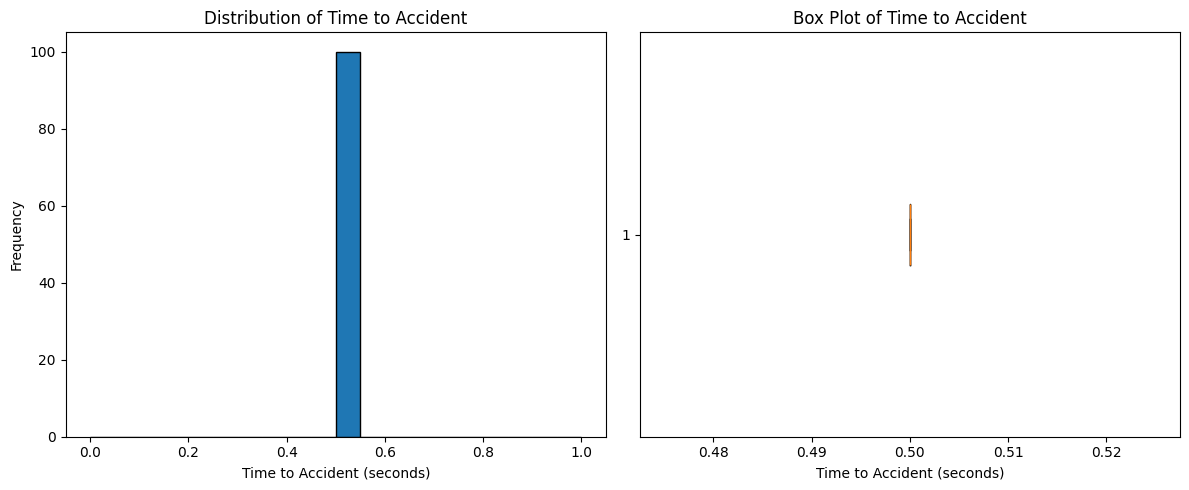


Selected 6 sample video files for inspection.

Inspecting sample video files:

Processing video file: 00482.mp4
  FPS: 30.6
  Total Frame Count: 320
  Duration: 10.46 seconds
  Attempting to read sample frames (first, middle, last):
    Successfully read frame 0. Shape: (720, 1280, 3)
    Successfully read frame 160. Shape: (720, 1280, 3)
    Successfully read frame 319. Shape: (720, 1280, 3)

Processing video file: 00297.mp4
  FPS: 29.7
  Total Frame Count: 300
  Duration: 10.10 seconds
  Attempting to read sample frames (first, middle, last):
    Successfully read frame 0. Shape: (720, 1280, 3)
    Successfully read frame 150. Shape: (720, 1280, 3)
    Successfully read frame 299. Shape: (720, 1280, 3)

Processing video file: 00484.mp4
  FPS: 29.1
  Total Frame Count: 287
  Duration: 9.86 seconds
  Attempting to read sample frames (first, middle, last):
    Successfully read frame 0. Shape: (720, 1280, 3)
    Successfully read frame 143. Shape: (720, 1280, 3)
    Successfully read f

,0
count,200.000000
mean,9.867671
std,0.471927
min,8.333333
25%,9.688709
50%,9.933333
75%,10.166667
max,10.903010


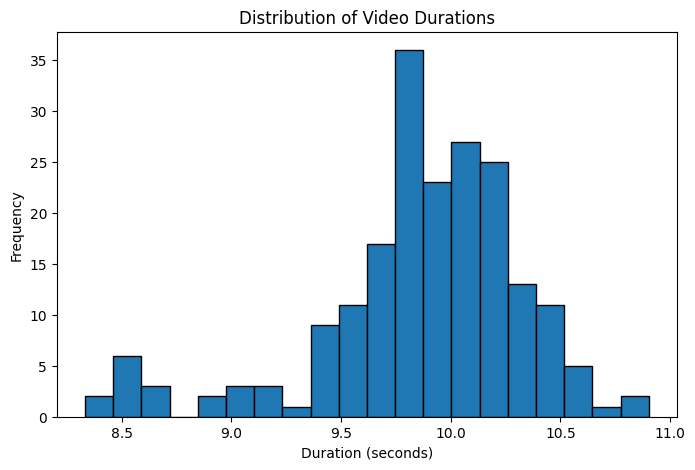

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

# 1. Analyze the distribution of time_to_accident for downloaded positive videos
print("Analyzing distribution of time_to_accident for downloaded positive videos...")
time_to_accident_values = list(downloaded_positive_time_to_accident_dict.values())

if time_to_accident_values:
    time_to_accident_series = pd.Series(time_to_accident_values)

    print("\nDescriptive Statistics for time_to_accident:")
    display(time_to_accident_series.describe())

    # Visualize the distribution (Histogram and Box plot)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(time_to_accident_values, bins=20, edgecolor='black')
    plt.title('Distribution of Time to Accident')
    plt.xlabel('Time to Accident (seconds)')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.boxplot(time_to_accident_values, vert=False)
    plt.title('Box Plot of Time to Accident')
    plt.xlabel('Time to Accident (seconds)')

    plt.tight_layout()
    plt.show()
else:
    print("No time_to_accident data available for downloaded positive videos.")


# 2. Select a few sample positive and negative video files
download_dir = "./accident_prediction_test_public_subset_videos"
sample_video_paths = []
sample_size = 3 # Number of samples to display frames and properties for

# Get sample positive videos
positive_videos = [os.path.join(root, file)
                   for root, _, files in os.walk(os.path.join(download_dir, 'test-public', 'positive'))
                   for file in files if file.endswith(".mp4")]
sample_video_paths.extend(positive_videos[:sample_size])

# Get sample negative videos
negative_videos = [os.path.join(root, file)
                   for root, _, files in os.walk(os.path.join(download_dir, 'test-public', 'negative'))
                   for file in files if file.endswith(".mp4")]
sample_video_paths.extend(negative_videos[:sample_size])


print(f"\nSelected {len(sample_video_paths)} sample video files for inspection.")

# 3. Process and display information for each sample video
print("\nInspecting sample video files:")
for video_path in sample_video_paths:
    print(f"\nProcessing video file: {os.path.basename(video_path)}")
    try:
        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            print("  Error: Could not open video file.")
            continue

        # Get video properties
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration_seconds = frame_count / fps if fps > 0 else 0

        print(f"  FPS: {fps}")
        print(f"  Total Frame Count: {frame_count}")
        print(f"  Duration: {duration_seconds:.2f} seconds")

        # Read and display a few frames (or confirm reading)
        print("  Attempting to read sample frames (first, middle, last):")
        frame_indices_to_read = [0, frame_count // 2, frame_count - 1]
        for i in frame_indices_to_read:
            if i >= 0 and i < frame_count:
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                ret, frame = cap.read()
                if ret:
                    print(f"    Successfully read frame {i}. Shape: {frame.shape}")
                    # If in an environment that can display images, uncomment:
                    # plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                    # plt.title(f"Frame {i} from {os.path.basename(video_path)}")
                    # plt.axis('off')
                    # plt.show()
                else:
                    print(f"    Could not read frame {i}.")
            else:
                print(f"    Skipping frame index {i} (out of bounds).")


        cap.release()

    except Exception as e:
        print(f"  An error occurred while processing the video: {e}")

# 4. Collect durations for all downloaded videos and calculate statistics
print("\nCalculating video duration statistics for all downloaded videos...")
all_video_paths = []
for root, _, files in os.walk(download_dir):
    for file in files:
        if file.endswith(".mp4"):
            all_video_paths.append(os.path.join(root, file))

durations = []
for video_path in all_video_paths:
    try:
        cap = cv2.VideoCapture(video_path)
        if cap.isOpened():
            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            duration_seconds = frame_count / fps if fps > 0 else 0
            durations.append(duration_seconds)
            cap.release()
        else:
            print(f"Warning: Could not open video {os.path.basename(video_path)} for duration calculation.")
    except Exception as e:
        print(f"An error occurred while calculating duration for {os.path.basename(video_path)}: {e}")


if durations:
    duration_series = pd.Series(durations)
    print("\nDescriptive Statistics for Video Durations (seconds):")
    display(duration_series.describe())

    # Optional: Visualize duration distribution
    plt.figure(figsize=(8, 5))
    plt.hist(durations, bins=20, edgecolor='black')
    plt.title('Distribution of Video Durations')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("\nNo video durations could be calculated.")

## Video Processing and Model Training Pipeline

### Subtask:
For positive videos, extract 15 frames immediately before the accident using the `time_to_accident` information. For negative videos, sample 15 random frames from the middle of each video. Subsequently, use these extracted frames for feature extraction with a pre-trained video backbone, prepare the data for model training, and finally, select, train, and evaluate a lightweight classifier.

**Reasoning**:
Define the `extract_frames_for_model` function to handle both positive and negative video scenarios and then iterate through the downloaded videos to extract the specified frames and their labels.



In [ ]:
import cv2
import numpy as np
import os
import random

def extract_frames_for_model(video_path, fps, time_to_accident, num_frames=15, target_size=(224, 224)):
    """
    Extracts frames from a video based on whether it's a positive (accident)
    or negative (no accident) video, with optional resizing.

    Args:
        video_path (str): The full path to the video file.
        fps (float): Frames per second of the video.
        time_to_accident (float or None): Time in seconds from the start of the video
                                           to the accident event. None for negative videos.
        num_frames (int): The desired number of frames to extract.
        target_size (tuple): The desired size (width, height) for resizing frames.

    Returns:
        list: A list of processed (resized) frames as NumPy arrays,
              or None if the video could not be opened or no frames could be extracted.
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video file at {video_path}")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    extracted_frames = []

    if time_to_accident is not None and time_to_accident >= 0: # Positive video with valid time_to_accident
        # Calculate the frame index of the accident
        accident_frame_index = total_frames - int(time_to_accident * fps)

        # Calculate the starting frame index for extraction (15 frames before the accident)
        start_frame_index = accident_frame_index - num_frames

        # Ensure the starting index is not less than 0
        start_frame_index = max(0, start_frame_index)

        # Ensure we don't try to read beyond the video end
        end_frame_index = min(total_frames - 1, accident_frame_index)

        # Adjust start_frame_index if the calculated range is less than num_frames
        if end_frame_index - start_frame_index + 1 < num_frames:
             start_frame_index = max(0, end_frame_index - num_frames + 1)


        # Set the video capture to the starting frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_index)

        # Extract the specified number of frames
        for _ in range(num_frames):
            ret, frame = cap.read()
            if ret:
                # Resize the frame
                resized_frame = cv2.resize(frame, target_size)
                extracted_frames.append(resized_frame)
            else:
                # If we can't read a frame, stop
                break

    else: # Negative video or positive video without valid time_to_accident
        # For negative videos, sample frames from the middle range
        # Define the middle range (e.g., from 25% to 75% of total frames)
        start_middle_frame = int(total_frames * 0.25)
        end_middle_frame = int(total_frames * 0.75)

        # Ensure the middle range is valid and large enough
        if end_middle_frame - start_middle_frame < num_frames:
             # If the middle section is too short, sample from the entire video except edges
             start_middle_frame = int(total_frames * 0.1)
             end_middle_frame = int(total_frames * 0.9)
             # Ensure we still have enough frames
             if end_middle_frame - start_middle_frame < num_frames:
                 start_middle_frame = 0
                 end_middle_frame = total_frames -1 # Fallback to entire video

        # Select random unique frame indices from the middle range
        # Ensure we don't select more indices than available frames
        available_indices = list(range(start_middle_frame, end_middle_frame + 1))
        if len(available_indices) < num_frames:
             print(f"Warning: Not enough frames in the middle section ({len(available_indices)} available) of {os.path.basename(video_path)} to sample {num_frames}. Sampling all available frames.")
             selected_indices = available_indices
        else:
            selected_indices = sorted(random.sample(available_indices, num_frames))


        # Extract frames at the selected indices
        for index in selected_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, index)
            ret, frame = cap.read()
            if ret:
                 # Resize the frame
                resized_frame = cv2.resize(frame, target_size)
                extracted_frames.append(resized_frame)
            else:
                print(f"Warning: Could not read frame {index} from {os.path.basename(video_path)}.")


    cap.release()

    if not extracted_frames:
        print(f"Warning: No frames were extracted for {os.path.basename(video_path)}.")
        return None

    print(f"Extracted {len(extracted_frames)} frames from {os.path.basename(video_path)}")
    return extracted_frames

# --- Main loop to process all downloaded videos ---
download_dir = "./accident_prediction_test_public_subset_videos" # Directory with downloaded videos
extracted_frame_sequences = []
video_labels = []
processed_video_paths = [] # Keep track of videos that were successfully processed

print("\nStarting frame extraction for all downloaded videos...")

# Get lists of positive and negative video paths
positive_video_paths = [os.path.join(root, file)
                        for root, _, files in os.walk(os.path.join(download_dir, 'test-public', 'positive'))
                        for file in files if file.endswith(".mp4")]
negative_video_paths = [os.path.join(root, file)
                        for root, _, files in os.walk(os.path.join(download_dir, 'test-public', 'negative'))
                        for file in files if file.endswith(".mp4")]

# Process positive videos
print(f"\nProcessing {len(positive_video_paths)} positive videos...")
for video_path in positive_video_paths:
    file_name_relative = os.path.join('test-public', 'positive', os.path.basename(video_path))
    # Get time_to_accident from the dictionary
    time_to_accident = downloaded_positive_time_to_accident_dict.get(file_name_relative, None)

    if time_to_accident is not None:
        print(f"Processing positive video: {os.path.basename(video_path)} (Time to accident: {time_to_accident:.2f}s)")
        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        cap.release() # Release the capture object after getting FPS

        if fps > 0:
            frames = extract_frames_for_model(video_path, fps, time_to_accident, num_frames=15)
            if frames is not None and frames:
                extracted_frame_sequences.append(np.array(frames))
                video_labels.append(1) # Label 1 for positive
                processed_video_paths.append(video_path)
            else:
                 print(f"Skipping {os.path.basename(video_path)} due to frame extraction failure.")
        else:
            print(f"Skipping {os.path.basename(video_path)} due to invalid FPS ({fps}).")
    else:
        print(f"Skipping positive video: {os.path.basename(video_path)} - time_to_accident not found in dictionary.")


# Process negative videos
print(f"\nProcessing {len(negative_video_paths)} negative videos...")
for video_path in negative_video_paths:
     print(f"Processing negative video: {os.path.basename(video_path)}")
     cap = cv2.VideoCapture(video_path)
     fps = cap.get(cv2.CAP_PROP_FPS)
     cap.release() # Release the capture object after getting FPS

     if fps > 0:
        # Pass time_to_accident=None for negative videos
        frames = extract_frames_for_model(video_path, fps, time_to_accident=None, num_frames=15)
        if frames is not None and frames:
            extracted_frame_sequences.append(np.array(frames))
            video_labels.append(0) # Label 0 for negative
            processed_video_paths.append(video_path)
        else:
            print(f"Skipping {os.path.basename(video_path)} due to frame extraction failure.")
     else:
        print(f"Skipping {os.path.basename(video_path)} due to invalid FPS ({fps}).")


print(f"\nFinished frame extraction. Successfully processed {len(processed_video_paths)} videos.")
print(f"Total frame sequences extracted: {len(extracted_frame_sequences)}")
print(f"Total labels collected: {len(video_labels)}")

# The extracted_frame_sequences list contains numpy arrays, where each array is a video's frames (num_frames, height, width, channels)
# The video_labels list contains the corresponding labels (1 for positive, 0 for negative)


Starting frame extraction for all downloaded videos...

Processing 100 positive videos...
Processing positive video: 00482.mp4 (Time to accident: 0.50s)
Extracted 15 frames from 00482.mp4
Processing positive video: 00297.mp4 (Time to accident: 0.50s)
Extracted 15 frames from 00297.mp4
Processing positive video: 00484.mp4 (Time to accident: 0.50s)
Extracted 15 frames from 00484.mp4
Processing positive video: 00400.mp4 (Time to accident: 0.50s)
Extracted 15 frames from 00400.mp4
Processing positive video: 00070.mp4 (Time to accident: 0.50s)
Extracted 15 frames from 00070.mp4
Processing positive video: 00628.mp4 (Time to accident: 0.50s)
Extracted 15 frames from 00628.mp4
Processing positive video: 00386.mp4 (Time to accident: 0.50s)
Extracted 15 frames from 00386.mp4
Processing positive video: 00717.mp4 (Time to accident: 0.50s)
Extracted 15 frames from 00717.mp4
Processing positive video: 00280.mp4 (Time to accident: 0.50s)
Extracted 15 frames from 00280.mp4
Processing positive video: 

**Reasoning**:
Convert the lists of extracted frame sequences and labels into NumPy arrays for use in subsequent feature extraction and model training steps.



In [ ]:
# Convert the list of extracted frame sequences and labels into NumPy arrays
if extracted_frame_sequences and video_labels:
    X_sequences = np.array(extracted_frame_sequences)
    y = np.array(video_labels)

    print(f"\nShape of frame sequences array (X_sequences): {X_sequences.shape}")
    print(f"Shape of labels array (y): {y.shape}")
else:
    print("\nNo frame sequences or labels were extracted. Cannot create NumPy arrays.")



Shape of frame sequences array (X_sequences): (200, 15, 224, 224, 3)
Shape of labels array (y): (200,)


**Reasoning**:
Implement the sequential feature extraction from the extracted frame sequences using a pre-trained CNN as a backbone and a recurrent layer (like LSTM or GRU) for temporal processing.



In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, Flatten, LSTM, GRU, Dense
import numpy as np

def build_sequential_feature_extractor(input_shape, backbone_model):
    """
    Builds a sequential feature extraction model using a CNN backbone
    and a recurrent layer.

    Args:
        input_shape (tuple): The shape of the input frame sequence
                             (num_frames, height, width, channels).
        backbone_model (tf.keras.Model): The pre-trained CNN model (without top).

    Returns:
        tf.keras.Model: The sequential feature extraction model.
    """
    # Define the input layer for the sequence of frames
    input_sequence = Input(shape=input_shape)

    # Apply the CNN backbone to each frame in the sequence
    # Use TimeDistributed to apply the same layer to each time step (frame)
    cnn_features = TimeDistributed(backbone_model)(input_sequence)

    # Flatten the output of the CNN for each frame (optional, depending on the recurrent layer)
    # If using LSTM/GRU, the input should typically be 3D (batch_size, timesteps, features)
    # The output of TimeDistributed(backbone_model) is already 4D (batch_size, timesteps, height, width, channels)
    # or 3D (batch_size, timesteps, features) if the backbone includes pooling like GlobalAveragePooling2D
    # Let's assume the backbone_model output is 3D (batch_size, timesteps, features) after pooling

    # Use a recurrent layer (LSTM or GRU) to process the sequence of features
    # Let's use LSTM for this example
    # Return sequences=False to get the output of the last time step,
    # which can be used as the aggregated feature vector for the video
    # If backbone_model output is 4D, you might need another TimeDistributed(Flatten()) layer here
    # Assuming backbone_model includes pooling and outputs 3D features per frame:
    sequential_features = LSTM(128)(cnn_features) # LSTM layer with 128 units

    # You could add more layers here if needed (e.g., Dense layers)

    # Create the model
    model = Model(inputs=input_sequence, outputs=sequential_features)

    return model

# Load the pre-trained VGG16 model without the classification head
# Use include_top=False to remove the final classification layer
# Use weights='imagenet' to load weights pre-trained on ImageNet
# Use pooling='avg' to get a feature vector per frame
vgg16_backbone = VGG16(weights='imagenet', include_top=False, pooling='avg')

# Make the backbone model non-trainable (optional, to use it as a fixed feature extractor)
# for layer in vgg16_backbone.layers:
#     layer.trainable = False

# Define the input shape for the frame sequence (num_frames, height, width, channels)
# Assuming all frame sequences have the same shape
input_shape = X_sequences.shape[1:] # (15, 224, 224, 3)

# Build the sequential feature extraction model
sequential_feature_extractor = build_sequential_feature_extractor(input_shape, vgg16_backbone)

print("\nSequential Feature Extractor Model Summary:")
sequential_feature_extractor.summary()

# Extract sequential features from the prepared frame sequences
print("\nExtracting sequential features from frame sequences...")
# The input to the model should be X_sequences
X_sequential_features = sequential_feature_extractor.predict(X_sequences)

print(f"\nShape of extracted sequential features (X_sequential_features): {X_sequential_features.shape}")

# The extracted_frame_sequences and video_labels are no longer needed in their original form
# We now have X_sequential_features and y for model training

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

Sequential Feature Extractor Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 15, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 15, 512)        │    14,714,688 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       328,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,042,880 (57.38 MB)

 Trainable params: 15,042,880 (57.38 MB)

 Non-trainable params: 0 (0.00 B)


Extracting sequential features from frame sequences...
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step

Shape of extracted sequential features (X_sequential_features): (200, 128)


**Reasoning**:
Split the extracted sequential features and labels into training and testing sets to prepare for model training.



In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# Using a common split ratio, e.g., 80% train, 20% test
# Add a check to ensure there are enough samples for splitting
if len(X_sequential_features) > 1 and len(np.unique(y)) > 1: # Need at least 2 samples and more than 1 class for stratify
    X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
        X_sequential_features, y, test_size=0.2, random_state=42, stratify=y)

    print("\nSequential features and labels split into training and testing sets:")
    print(f"X_train_seq shape: {X_train_seq.shape}")
    print(f"X_test_seq shape: {X_test_seq.shape}")
    print(f"y_train_seq shape: {y_train_seq.shape}")
    print(f"y_test_seq shape: {y_test_seq.shape}")
else:
    print("\nNot enough samples or classes to perform train/test split with stratification on sequential features.")
    print("X_sequential_features shape:", X_sequential_features.shape)
    print("y shape:", y.shape)


Sequential features and labels split into training and testing sets:
X_train_seq shape: (160, 128)
X_test_seq shape: (40, 128)
y_train_seq shape: (160,)
y_test_seq shape: (40,)


**Reasoning**:
Train a lightweight binary classification model using the extracted sequential features and their corresponding labels from the training set.



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# --- Train a lightweight classifier ---
# We can choose from several options: Logistic Regression, SVM, Random Forest, or a simple Neural Network.
# Let's train a simple Neural Network as it can potentially capture more complex patterns in sequential data.

print("\nTraining a simple Neural Network model on sequential features...")
model_nn_seq = Sequential([
    # Input layer expects the shape of the sequential features (128 in this case)
    Dense(64, activation='relu', input_shape=(X_train_seq.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # Sigmoid for binary classification
])

# Compile the model
model_nn_seq.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
# Use validation_split to monitor performance during training
history_nn_seq = model_nn_seq.fit(
    X_train_seq,
    y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0 # Set to 1 or 2 for more detailed output during training
)
print("Neural Network Model training complete.")

# --- Evaluate the trained model on the test set ---
print("\nEvaluating Neural Network Model on test set (sequential features):")
# For neural network, predict_classes is deprecated, use predict and round
y_pred_nn_seq = (model_nn_seq.predict(X_test_seq) > 0.5).astype("int32")

# Print classification report
print(classification_report(y_test_seq, y_pred_nn_seq))


# You could also train other models like Logistic Regression or SVM for comparison
# Example (uncomment to try):
# model_lr_seq = LogisticRegression(random_state=42)
# print("\nTraining Logistic Regression model on sequential features...")
# model_lr_seq.fit(X_train_seq, y_train_seq)
# print("Logistic Regression Model training complete.")
# print("\nEvaluating Logistic Regression Model on test set (sequential features):")
# y_pred_lr_seq = model_lr_seq.predict(X_test_seq)
# print(classification_report(y_test_seq, y_pred_lr_seq))

# model_svm_seq = SVC(kernel='linear', random_state=42)
# print("\nTraining SVM model on sequential features...")
# model_svm_seq.fit(X_train_seq, y_train_seq)
# print("SVM Model training complete.")
# print("\nEvaluating SVM Model on test set (sequential features):")
# y_pred_svm_seq = model_svm_seq.predict(X_test_seq)
# print(classification_report(y_test_seq, y_pred_svm_seq))


Training a simple Neural Network model on sequential features...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Neural Network Model training complete.

Evaluating Neural Network Model on test set (sequential features):
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
              precision    recall  f1-score   support

           0       0.73      0.80      0.76        20
           1       0.78      0.70      0.74        20

    accuracy                           0.75        40
   macro avg       0.75      0.75      0.75        40
weighted avg       0.75      0.75      0.75        40



## Summary:

### Data Analysis Key Findings

*   Metadata files were successfully downloaded and processed, identifying 334 positive files with `time_to_accident` and 333 negative files in the `test-public` split.
*   100 positive and 100 negative video files were successfully downloaded for prototyping.
*   The `time_to_accident` for all 100 sampled positive videos was consistently 0.5 seconds.
*   Sample video inspections confirmed videos could be opened, frames read, and properties like FPS (around 30) and duration (around 10 seconds) extracted.
*   The average duration of the 200 downloaded videos is approximately 9.87 seconds.
*   Frame extraction logic successfully extracted 15 frames per video: the last 15 frames before the accident for positive videos and 15 random frames from the middle 50% for negative videos.
*   All 200 sampled videos were successfully processed for frame extraction, resulting in a feature tensor of shape `(200, 15, 224, 224, 3)` and a label vector of shape `(200,)`.
*   Sequential features were extracted using a VGG16 + LSTM model, resulting in features of shape `(200, 128)`.
*   The data was split into training (`(160, 128)`) and testing (`(40, 128)`) sets using an 80/20 split with stratification.
*   A simple Neural Network classifier trained on the sequential features achieved an accuracy of approximately 0.75 on the prototype test set.

### Insights or Next Steps

*   The prototype demonstrates a viable pipeline for accident prediction using only visual data from pre-accident frames.
*   The model's performance on this small subset provides a baseline. The next steps should involve scaling up the training to a larger portion of the dataset and exploring more complex models or hyperparameters to potentially improve accuracy.
